# Altimetry case study: Bodrum tide gauge station in Southwest Turkey
# Comparing a single Sentinel-3 fly-by data to the in-situ tide gauge data 

I have recently completed the EUMETSAT tutorials [here](https://classroom.eumetsat.int/course/section.php?id=3904) and wanted to independently apply what I learned there. In this notebook I will go step-by-step and try to compare the data from a single fly-by of Sentinel-3 satellite in the vicinity of the city of Bodrum in southwest Turkey, along the mediterrenean coast with the local tide gauge.

For this study we will use Bodrum tide gauge data from IOC sea level monitoring and a SRAL Level2 dataset from Sentinel-3 satellite. Details of datasets are described below in the corresponding section. The metric that will be used to measure the compatibility of two estimates is the Sea Surface Height Anomaly (SSHA) from the satellite and the relative gauge value which is the measurement subtracted from the mean within a given time period.

## Location

Bodrum is arguably the most popular domestic touristic destination in Turkey. It is a peninsula with a very irregular coastline. Due to nature of Aegean sea, it also has multiple islands around itself. As satellite altimetry tends to be less accurate in the vicinity of coasts, matching tide gauge trends in Bodrum is expected to be more difficult compared to easier coastal geometries. Below the Bodrum area is visualized with Bodrum tide gauge location highlighted.

In [1]:
%matplotlib inline

import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

## Datasets

### Satellite data

**Attribution: This study uses datasets from EUMETSAT Metop SRAL Level 2 Altimetry Global - Sentinel-3 (2025)**

In order to find a suitable fly-by, I searched for L2 datasets with Altimetry information. Using the EUMETSAT map tool I drew a box around Bodrum and listed the fly-by datasets. I looked at satellite tracks from August and picked one that passes almost directly over the city of Bodrum. For experts, the dataset name is:

*S3B_SR_2_WAT____20250805T194306_20250805T195144_20250805T203716_0517_109_299______MAR_O_NR_G61.SEN3*

It is a fly-by coming from North Africa (ascending), passing over Turkish south and west coasts between 19:43-19:51 UTC on 5th of August, 2025. This is how the satellite track looked like on EUMETSAT user portal:

<figure style="text-align:center;">
  <img src="images/track.png" 
       alt="Track" 
       width="550" 
       style="border:2px solid black;">
  <figcaption style="font-style:italic; color:gray; margin-top:5px;">
    Figure 1. Screenshot from EUMETSAT user portal, showing the satellite track of selected dataset.
  </figcaption>
</figure>

As can be seen, at least by eye, it has perfect proximity to the town. We use the *enhanced* set, as reduced and standard sets found to be not including the SSHA variable we wanted to use here. The dataset will be inspected further below.

### In-site tide gauge data

Limiting myself to the extend of satellite dataset, I downloaded the tide gauge values for the Bodrum station (BDRM) from [SEA LEVEL STATION MONITORING FACILITY](https://www.ioc-sealevelmonitoring.org/station.php?code=bodr) for 5th of August 19:43-19:51. Since we want to make a comparison to SSHA value from satellite, I recorded the reported gauge mean value as well, to subtract it from measured values to find the relative height change. The gauge mean, by centering 5th of August in the middle of the time range is : 12h (1.86m), daily (1.89m), weekly (1.91m) and monthly (1.92m). Since this website provides time values also in UTC, there is no conversion between time units needed. The gauge has a measurement frequency of 2 Hz, thus it provides far less points compared to satellite dataset. This dataset will also be inspected further below.

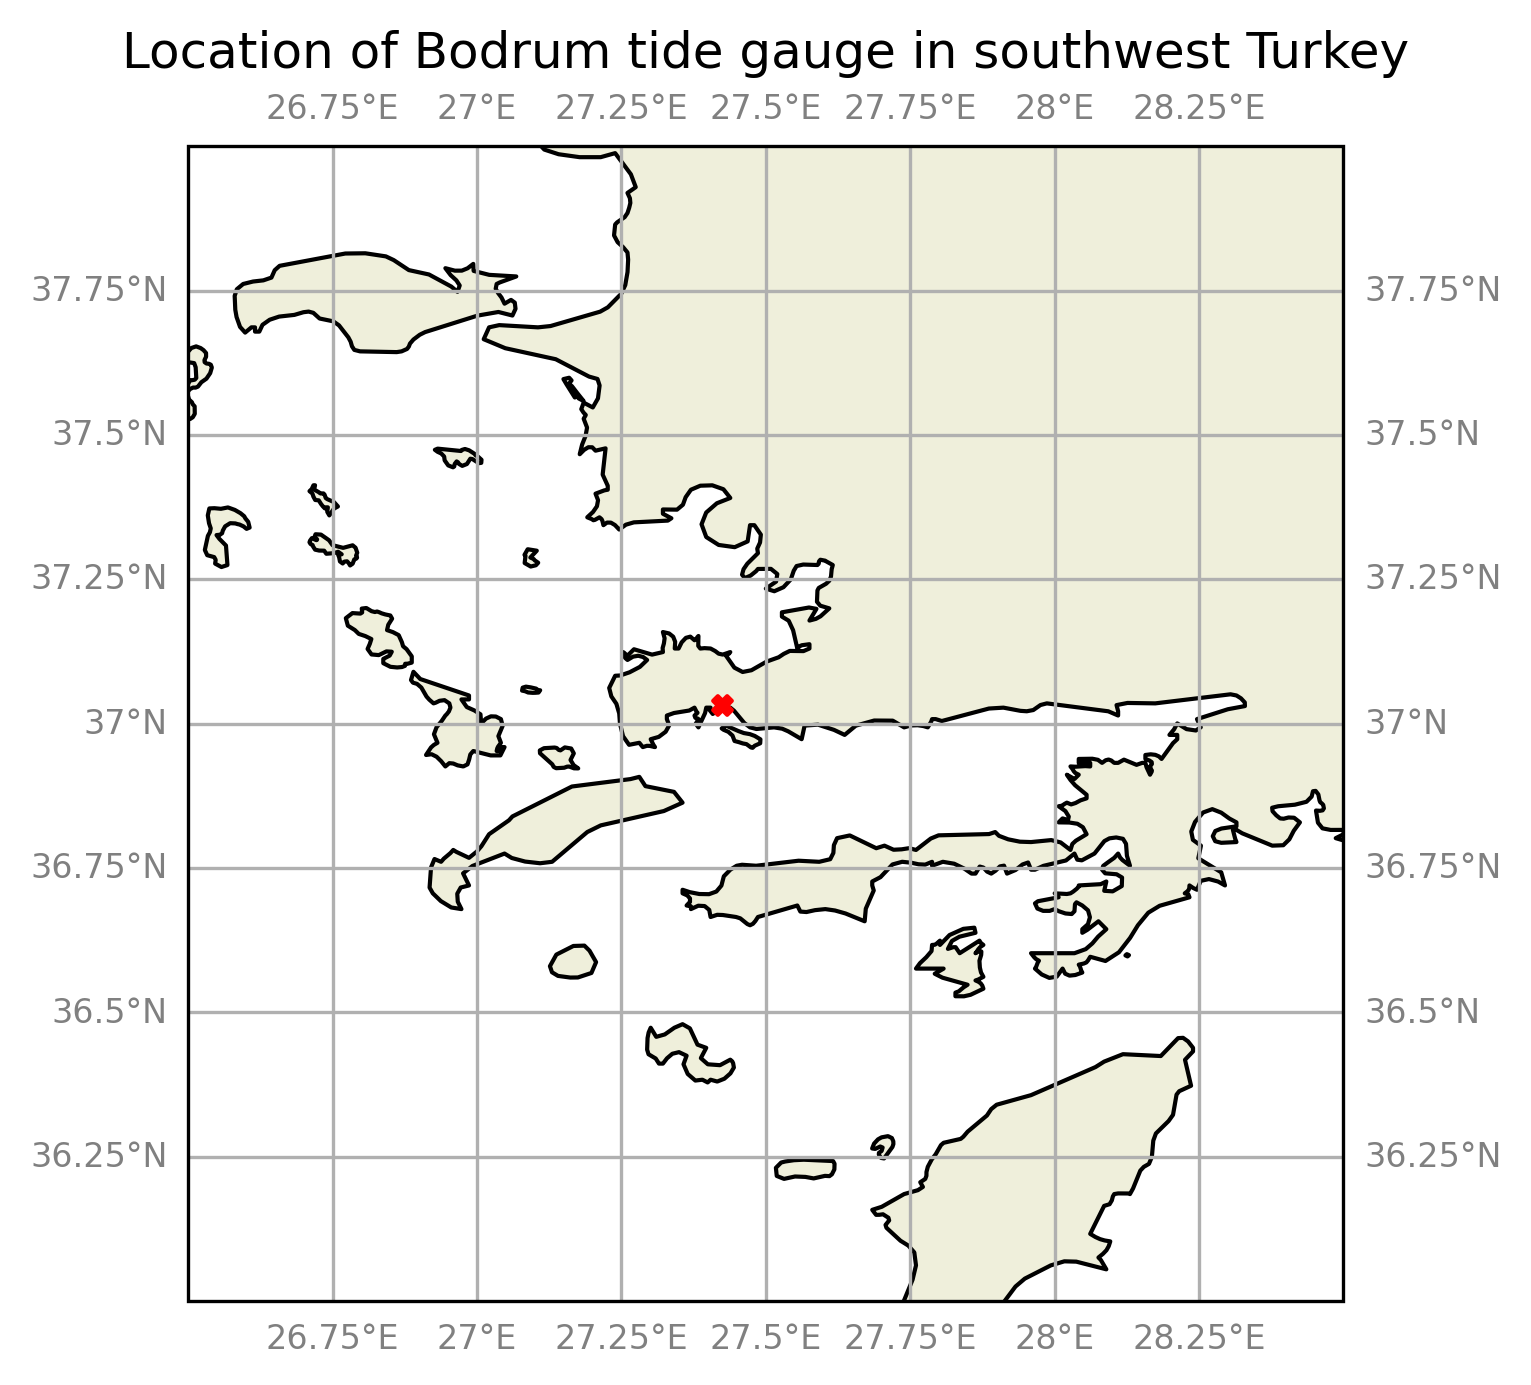

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["figure.figsize"] = (12,8)
plt.ioff()

# This can be 10,50 or 110 (weird, why?)
land_resolution = '10m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', land_resolution,
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

fig1 = plt.figure(figsize=(5, 5), dpi=300)

m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
m.set_extent([26.5, 28.5, 36, 38], crs=ccrs.PlateCarree())
m.coastlines(resolution=land_resolution, color='black', linewidth=0.1)
m.add_feature(land_poly)

g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 8, 'color': 'gray'}
g1.ylabel_style = {'size': 8, 'color': 'gray'}


m.set_title('Location of Bodrum tide gauge in southwest Turkey', size=12)
m.scatter(
    [27.423453], [37.03217],
    transform=ccrs.PlateCarree(),
    color="red",  
    s=20,         
    marker="X",
    zorder=5       
)
plt.savefig('fig_range')
plt.show()

## Inspection and cleaning of satellite dataset

#### Content and format of the dataset

We start by reading-in and checking the content and important parameters of the satellite dataset.

In [3]:
# Read-in the netCDF file
INFILE = "/Users/oncel/Downloads/aug25_bodrum50_standard_measurement.nc"


In [4]:
# Use 1Hz ku-band parameters. There is also _20_ku version with 20Hz.

time_satellite='time_01'
ssha_satellite='ssha_01_ku'
lat_satellite='lat_01'
lon_satellite='lon_01'

nc_data = nc.Dataset(os.path.join(INFILE))
nc_time_var = nc_data.variables[time_satellite]
nc_time_var.ncattrs()

['long_name', 'units', 'standard_name', 'calendar']

In [5]:
# List variables present in the dataset
for var_name in nc_data.variables.keys():
    print(var_name)

time_01
time_20_ku
time_20_c
UTC_day_01
UTC_sec_01
UTC_day_20_ku
UTC_sec_20_ku
UTC_day_20_c
UTC_sec_20_c
UTC_time_1hz_20_ku
UTC_time_1hz_20_c
lat_01
lon_01
lat_20_ku
lon_20_ku
lat_20_c
lon_20_c
lat_cor_20_ku
lon_cor_20_ku
lat_cor_20_c
lon_cor_20_c
surf_type_01
surf_type_20_ku
surf_type_20_c
surf_class_01
surf_class_20_ku
surf_class_20_c
rad_surf_type_01
angle_coast_01
angle_coast_20_ku
angle_coast_20_c
dist_coast_01
dist_coast_20_ku
dist_coast_20_c
alt_01
alt_20_ku
alt_20_c
orb_alt_rate_01
orb_alt_rate_20_ku
orb_alt_rate_20_c
agc_01_ku
agc_01_c
agc_01_plrm_ku
agc_numval_01_ku
agc_numval_01_c
agc_numval_01_plrm_ku
agc_rms_01_ku
agc_rms_01_c
agc_rms_01_plrm_ku
range_ocean_01_ku
range_ocean_01_c
range_ocean_01_plrm_ku
range_ocean_20_ku
range_ocean_20_c
range_ocean_20_plrm_ku
range_ocean_qual_01_ku
range_ocean_qual_01_c
range_ocean_qual_01_plrm_ku
range_ocean_qual_20_ku
range_ocean_qual_20_c
range_ocean_qual_20_plrm_ku
range_ocean_rms_01_ku
range_ocean_rms_01_c
range_ocean_rms_01_plrm_ku
r

#### There are variables related to SSHA present in the dataset. We also need temporal and spatial coordinates.

In [6]:
# Check the time format
cal = nc_time_var.getncattr('calendar')
date_units = nc_time_var.getncattr('units')

print(cal)
print(date_units)

gregorian
seconds since 2000-01-01 00:00:00.0


The calendar is not we are used to. It has the units of seconds since Y2K. So we re-format it to our more useful form:

In [7]:
dtime = nc.num2date(nc_time_var[:],date_units,calendar=cal, only_use_cftime_datetimes=False)

In [8]:
dtime

masked_array(data=[real_datetime(2025, 8, 5, 19, 43, 6),
                   real_datetime(2025, 8, 5, 19, 43, 7),
                   real_datetime(2025, 8, 5, 19, 43, 8),
                   real_datetime(2025, 8, 5, 19, 43, 9),
                   real_datetime(2025, 8, 5, 19, 43, 10),
                   real_datetime(2025, 8, 5, 19, 43, 11),
                   real_datetime(2025, 8, 5, 19, 43, 12),
                   real_datetime(2025, 8, 5, 19, 43, 13),
                   real_datetime(2025, 8, 5, 19, 43, 14),
                   real_datetime(2025, 8, 5, 19, 43, 15),
                   real_datetime(2025, 8, 5, 19, 43, 16),
                   real_datetime(2025, 8, 5, 19, 43, 17),
                   real_datetime(2025, 8, 5, 19, 43, 18),
                   real_datetime(2025, 8, 5, 19, 43, 19),
                   real_datetime(2025, 8, 5, 19, 43, 20),
                   real_datetime(2025, 8, 5, 19, 43, 21),
                   real_datetime(2025, 8, 5, 19, 43, 22),
                  

#### Inspection of values and parameters

We also want to use the quality and error parameters related to SSHA for data cleaning

In [9]:
# Extract SSHA values
ssha = nc_data.variables[ssha_satellite][:].filled(np.nan)
quality = nc_data.variables["quality_ssha_01_ku"][:]
rms     = nc_data.variables["range_ocean_rms_01_ku"][:].filled(np.nan)

# Print hour:minute:second and SSHA
for t, v,r, z in zip(dtime, ssha,rms, quality):
    print(t.strftime("%H:%M:%S"), v,r,z)

19:43:06 nan nan --
19:43:07 nan nan --
19:43:08 nan nan --
19:43:09 nan nan --
19:43:10 nan nan --
19:43:11 0.264 0.041600000000000005 0
19:43:12 0.224 0.0381 0
19:43:13 0.248 0.0361 0
19:43:14 0.273 0.0437 0
19:43:15 0.268 0.0332 0
19:43:16 0.245 0.0316 0
19:43:17 0.223 0.051800000000000006 0
19:43:18 0.188 0.0369 0
19:43:19 0.153 0.044700000000000004 0
19:43:20 0.134 0.0333 0
19:43:21 0.114 0.0529 0
19:43:22 0.116 0.044000000000000004 0
19:43:23 0.131 0.0212 0
19:43:24 0.106 0.0422 0
19:43:25 0.08 0.031200000000000002 0
19:43:26 0.07100000000000001 0.0317 0
19:43:27 0.076 0.0495 0
19:43:28 0.08600000000000001 0.0426 0
19:43:29 0.095 0.0332 0
19:43:30 0.079 0.046700000000000005 0
19:43:31 0.07100000000000001 0.058800000000000005 0
19:43:32 0.069 0.0468 0
19:43:33 0.085 0.044500000000000005 0
19:43:34 0.067 0.0468 0
19:43:35 0.064 0.038400000000000004 0
19:43:36 0.065 0.0379 0
19:43:37 0.059000000000000004 0.039900000000000005 0
19:43:38 0.044 0.0455 0
19:43:39 0.044 0.047 0
19:43:40 

Note that there are some NaN values where parameter is not computed. We also have different types of quality flags: --, 0 or 1. NaN values or non-zero quality flags indicate issues. But for the moment we leave them, later to be inspected.

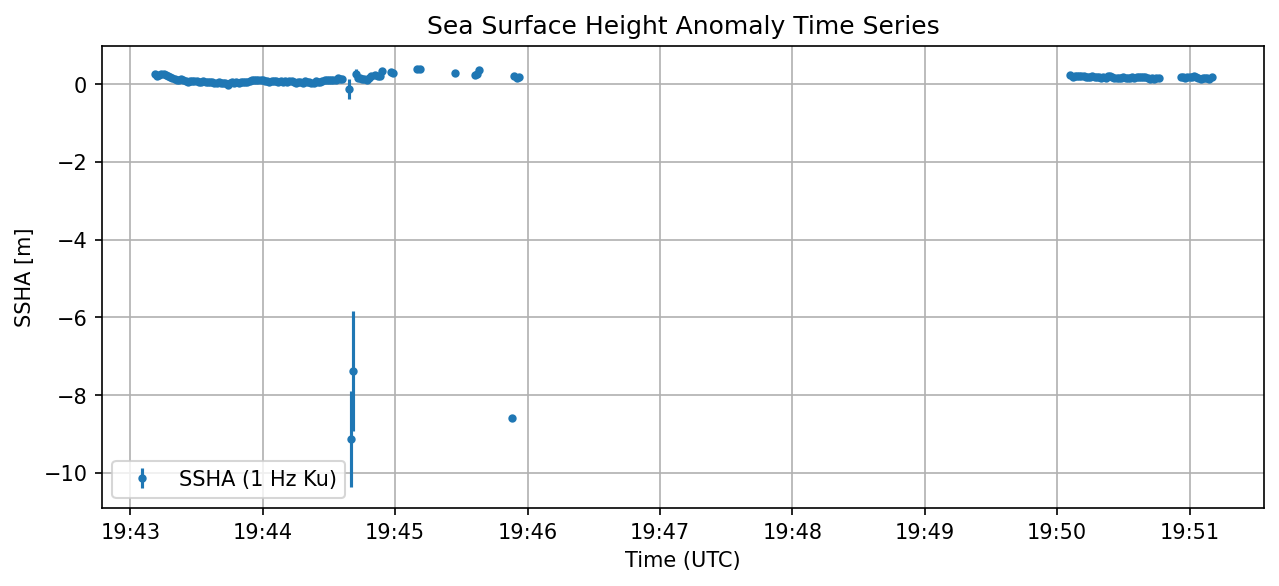

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot time series
fig, ax = plt.subplots(figsize=(10,4), dpi=150)

ax.errorbar(dtime, ssha, yerr=rms, fmt=".", label="SSHA (1 Hz Ku)")

# Format xaxis to show only hours
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

ax.set_xlabel("Time (UTC)")
ax.set_ylabel("SSHA [m]")
ax.set_title("Sea Surface Height Anomaly Time Series")
ax.legend()
ax.grid(True)

plt.show()

**Attribution: Above plot contains data from EUMETSAT Metop SRAL Level 2 Altimetry Global - Sentinel-3 (2025)**

Here we can see that in this dataset we have some points that are too extreme. Typically eyebrows are to be raised if |SSHA| > 1 m. Let's check the actual number of such points in the dataset:

In [11]:
# count how many values exceed ±1 m
count = np.sum(np.abs(nc_data.variables["ssha_01_ku"][:]) > 1) 
print(count)

3


Keeping the issues with height and NaNs in mind, let's now map the satellite track to check if our downloaded dataset corresponds to what EUMETSAT map viewer showed and have some more insight on data points

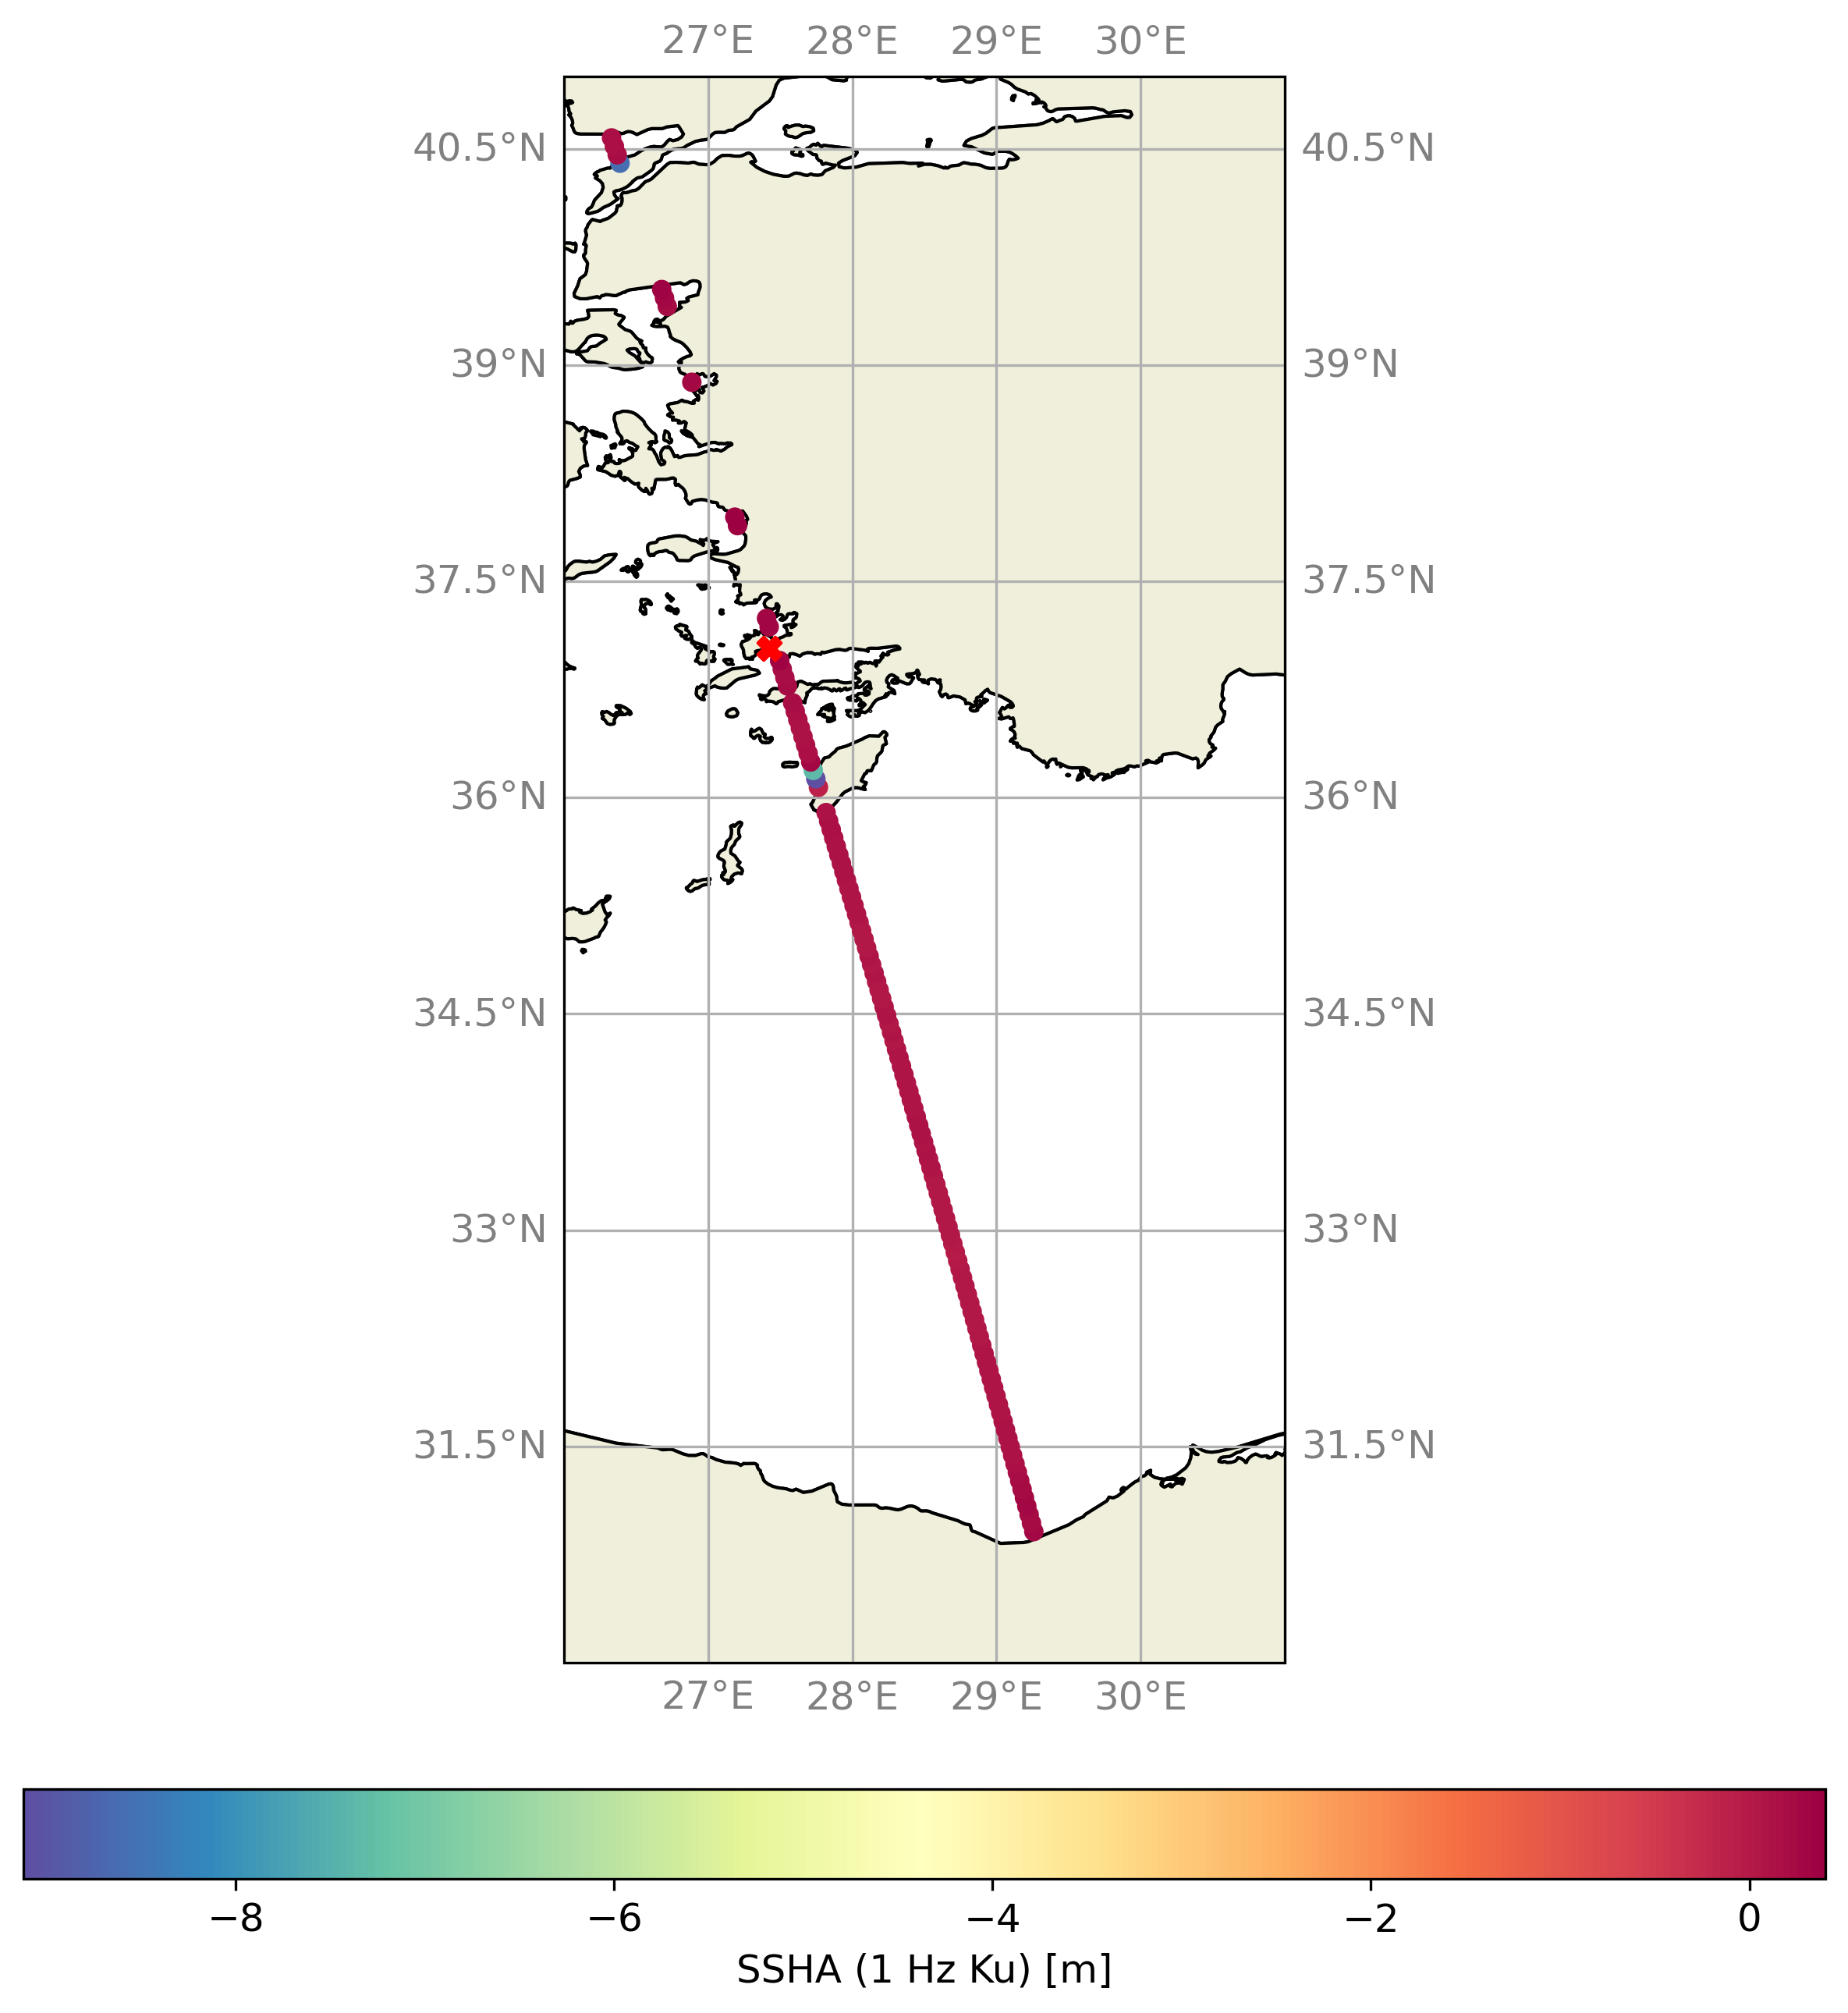

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()

# Background (land)
land_resolution = '10m'
land_poly = cfeature.NaturalEarthFeature(
    'physical', 'land', land_resolution,
    edgecolor='k',
    facecolor=cfeature.COLORS['land']
)

fig1 = plt.figure(figsize=(15, 10), dpi=300)

# Data Frame
ssha = nc_data.variables[ssha_satellite][:].filled(np.nan)
lat  = nc_data.variables[lat_satellite][:]
lon  = nc_data.variables[lon_satellite][:]
time = [pd.Timestamp(str(t)) for t in dtime]   # convert to pandas timestamps

df = pd.DataFrame({"time": time, "lat": lat, "lon": lon, "ssha": ssha})

# Projection
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

# SSHA range
low_pc  = np.nanmin(df["ssha"])
high_pc = np.nanmax(df["ssha"])
df["ssha_clipped"] = df["ssha"].clip(lower=low_pc, upper=high_pc)

# Map bound
#m.set_extent([26, 29, 35, 39], crs=ccrs.PlateCarree())
m.set_extent([26, 31, 30, 41], crs=ccrs.PlateCarree())
# --- Scatter plot ---
f1 = m.scatter(
    df["lon"], df["lat"], c=df["ssha_clipped"],
    cmap='Spectral_r', marker='o',
    edgecolors=None, linewidth=0.0,
    vmin=low_pc, vmax=high_pc,
    transform=ccrs.PlateCarree(), zorder=5
)

# Map features
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)

g1 = m.gridlines(draw_labels=True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 12, 'color': 'gray'}
g1.ylabel_style = {'size': 12, 'color': 'gray'}

cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('SSHA (1 Hz Ku) [m]', size=12)

# Tide gauge
m.scatter(
    [27.423453], [37.03217],
    transform=ccrs.PlateCarree(),
    color="red", s=50, marker="X", zorder=5
)

# Time range
start = pd.Timestamp("2025-08-05 19:43:00")
end   = pd.Timestamp("2025-08-05 19:44:00")

plt.savefig('fig_range')
plt.show()


**Attribution: Above plot contains data from EUMETSAT Metop SRAL Level 2 Altimetry Global - Sentinel-3 (2025)**

I have limited the range of track such that only Mediterranean and Aegean parts are shown since these are the once that could represent the sea level conditions in Bodrum, which is marked with a thick red X. From this map, we can see that there are three light-colored data points indicating SSHA < -6 or so. The number three matches with our previous count of such values in the dataset. From first look it seems like the issue is happening when the satellite tries to measure sea level around a coast or on land which probably leads to weird errors. 

Let's look closer to the two points around the island of Rhodes:

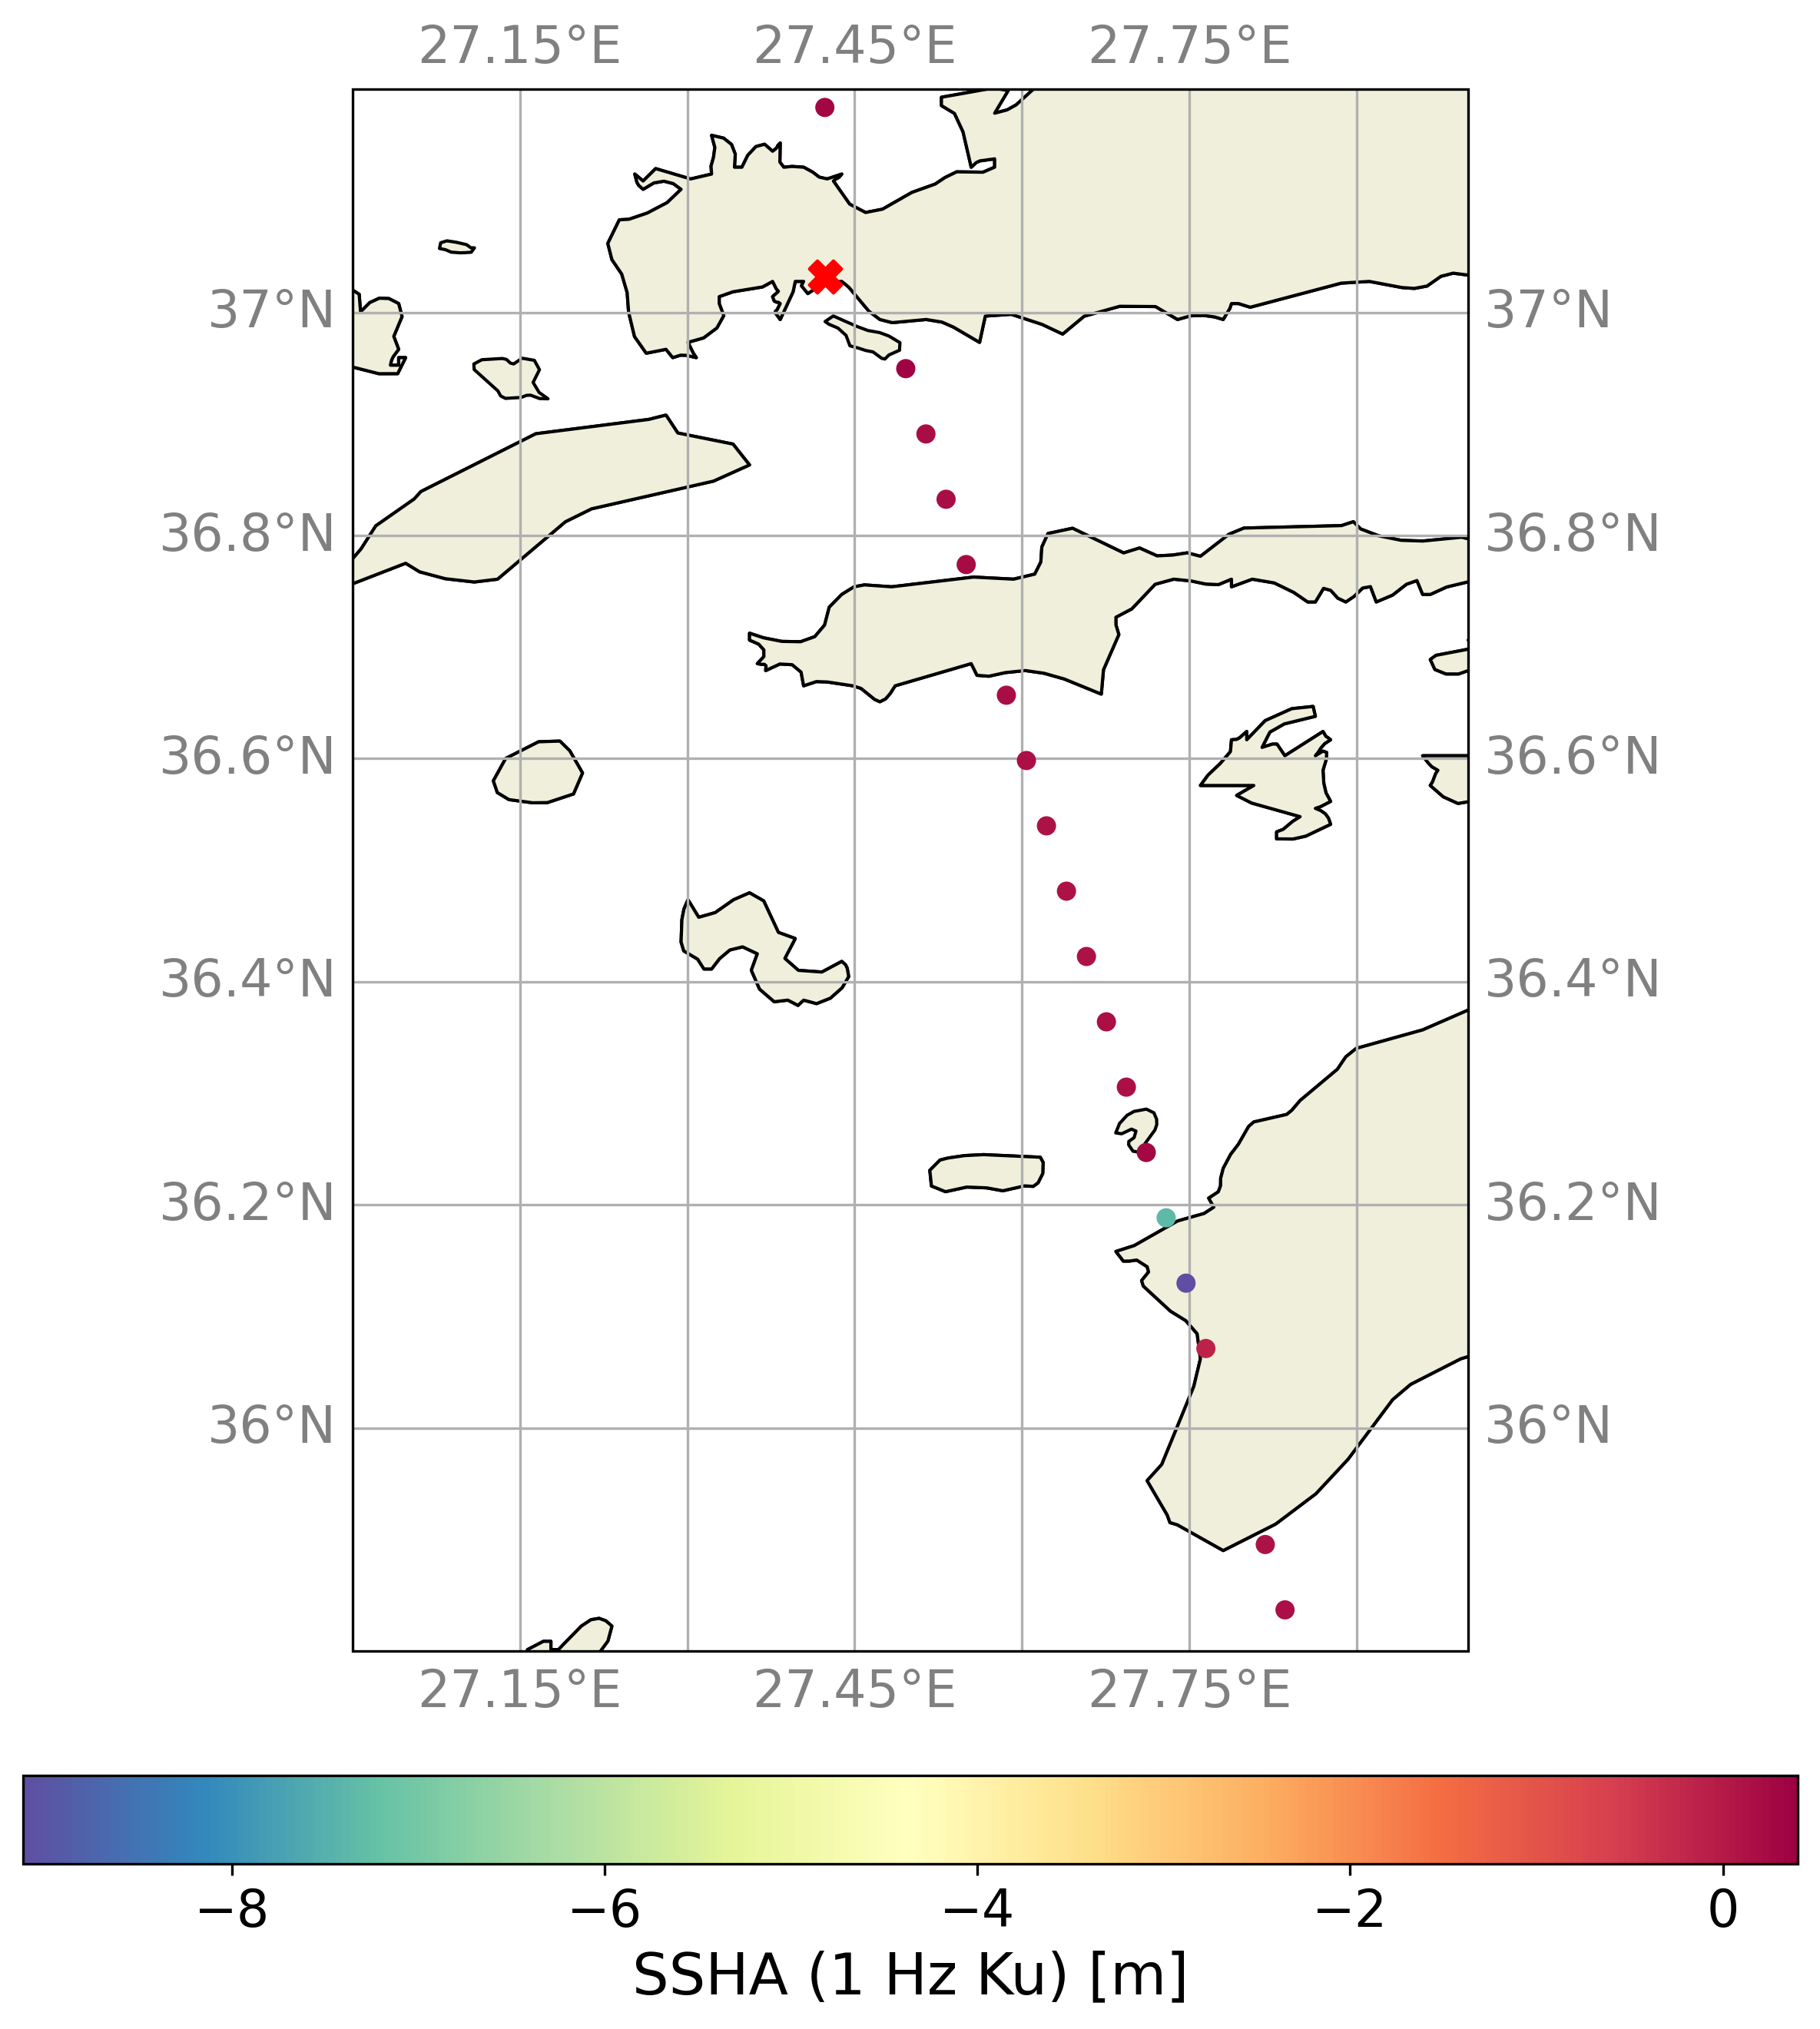

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()

# --- Land settings ---
land_resolution = '10m'
land_poly = cfeature.NaturalEarthFeature(
    'physical', 'land', land_resolution,
    edgecolor='k',
    facecolor=cfeature.COLORS['land']
)

fig1 = plt.figure(figsize=(10, 10), dpi=300)

# --- Build DataFrame with time, lat, lon, ssha ---
ssha = nc_data.variables[ssha_satellite][:].filled(np.nan)
lat  = nc_data.variables[lat_satellite][:]
lon  = nc_data.variables[lon_satellite][:]
time = [pd.Timestamp(str(t)) for t in dtime]   # convert to pandas timestamps

df = pd.DataFrame({"time": time, "lat": lat, "lon": lon, "ssha": ssha})

# --- Define projection ---
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

# --- Truncate SSHA range for visualization ---
low_pc  = np.nanmin(df["ssha"])
high_pc = np.nanmax(df["ssha"])
df["ssha_clipped"] = df["ssha"].clip(lower=low_pc, upper=high_pc)

# --- Focus extent ---
m.set_extent([27, 28, 35.8, 37.2], crs=ccrs.PlateCarree())

# --- Scatter plot ---
f1 = m.scatter(
    df["lon"], df["lat"], c=df["ssha_clipped"],
    cmap='Spectral_r', marker='o',
    edgecolors=None, linewidth=0.0,
    vmin=low_pc, vmax=high_pc,
    transform=ccrs.PlateCarree(), zorder=5
)

# --- Coastlines and land ---
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)

# --- Gridlines ---
g1 = m.gridlines(draw_labels=True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}

# --- Colorbar ---
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('SSHA (1 Hz Ku) [m]', size=18)

# --- Add tide gauge marker ---
m.scatter(
    [27.423453], [37.03217],
    transform=ccrs.PlateCarree(),
    color="red", s=100, marker="X", zorder=5
)

# --- Add labels only between 19:44:30 and 19:45:11 ---
start = pd.Timestamp("2025-08-05 19:44:21")
end   = pd.Timestamp("2025-08-05 19:45:27")

plt.savefig('fig_range')
plt.show()


**Attribution: Above plot contains data from EUMETSAT Metop SRAL Level 2 Altimetry Global - Sentinel-3 (2025)**

It indeed looks like a coast/land interference issue when the sensor/algorithm expects a sea surface. Let's try to gain more insight by putting quality flags and SSHA values next to data points and zoom a bit out to cover whole relevant coast of Turkey

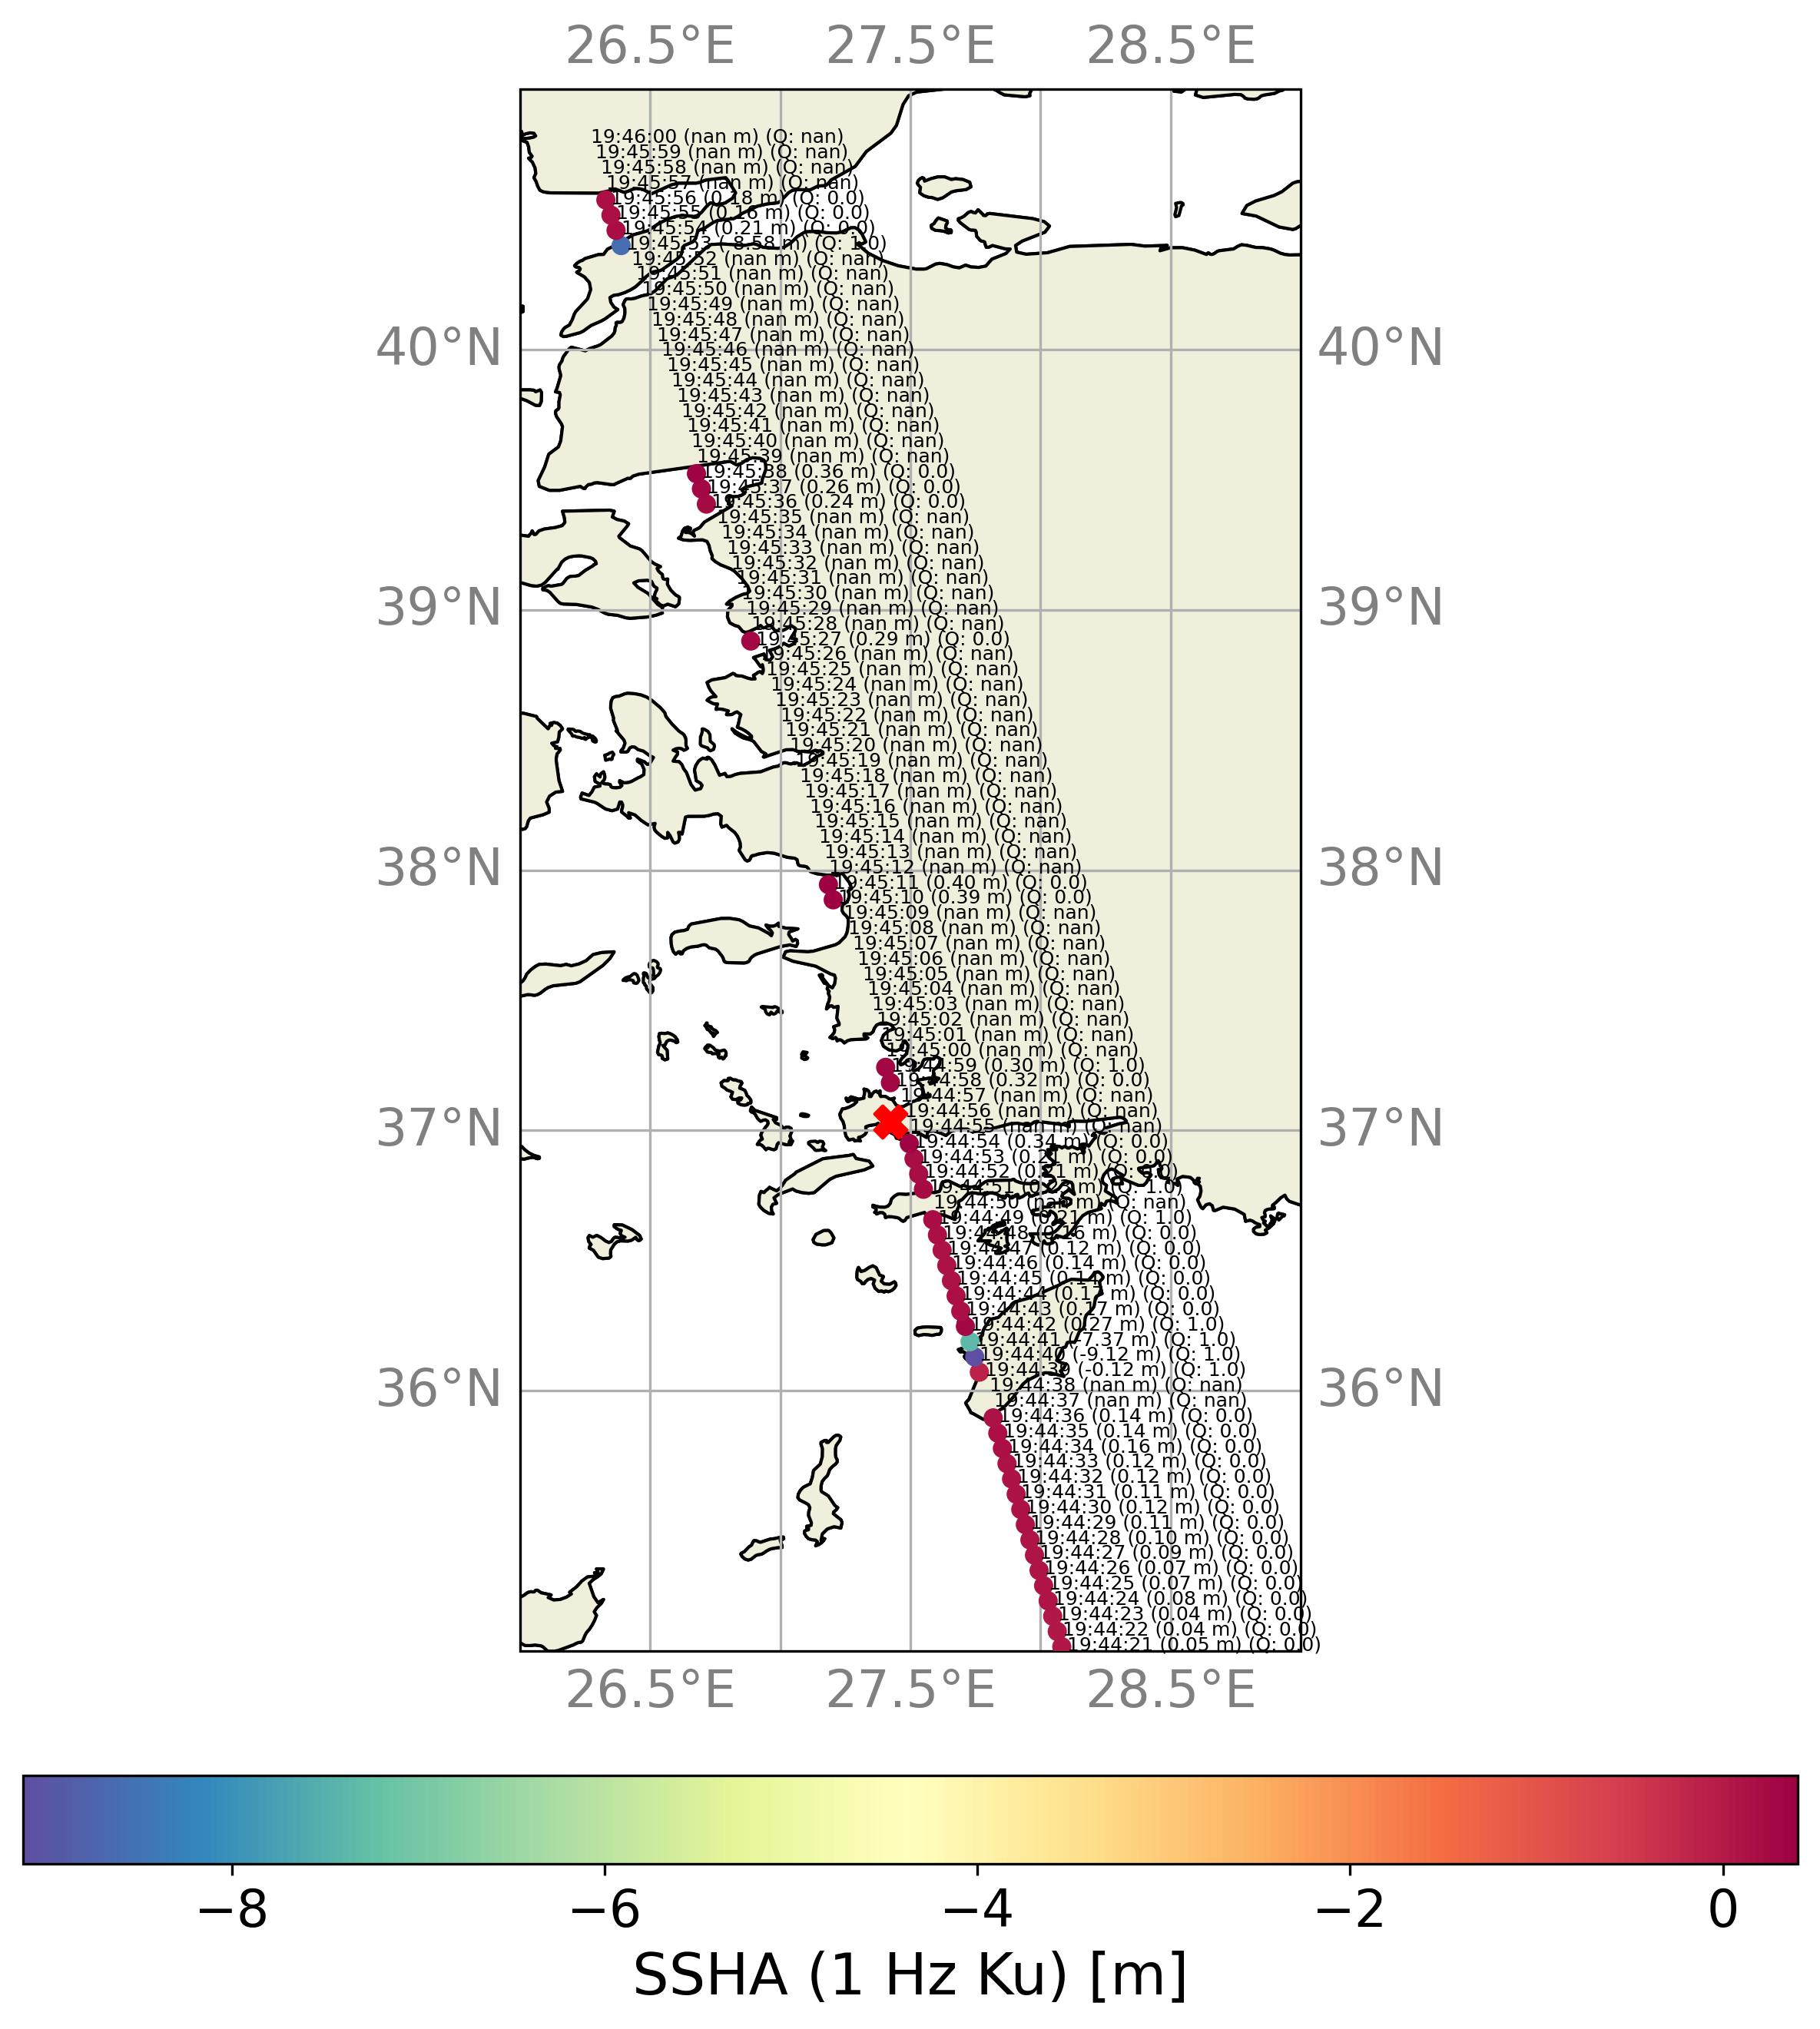

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()

# Land map
land_resolution = '10m'
land_poly = cfeature.NaturalEarthFeature(
    'physical', 'land', land_resolution,
    edgecolor='k',
    facecolor=cfeature.COLORS['land']
)

fig1 = plt.figure(figsize=(10, 10), dpi=300)

# DF
ssha = nc_data.variables["ssha_01_ku"][:].filled(np.nan)
quality = nc_data.variables["quality_ssha_01_ku"][:]
lat  = nc_data.variables["lat_01"][:]
lon  = nc_data.variables["lon_01"][:]
time = [pd.Timestamp(str(t)) for t in dtime]   # convert to pandas timestamps

df = pd.DataFrame({"time": time, "lat": lat, "lon": lon, "ssha": ssha, "quality": quality})

# projection
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

# SSHA range
low_pc  = np.nanmin(df["ssha"])
high_pc = np.nanmax(df["ssha"])
df["ssha_clipped"] = df["ssha"].clip(lower=low_pc, upper=high_pc)

# Geographic bound
m.set_extent([26, 29, 35, 41], crs=ccrs.PlateCarree())

# Plot
f1 = m.scatter(
    df["lon"], df["lat"], c=df["ssha_clipped"],
    cmap='Spectral_r', marker='o',
    edgecolors=None, linewidth=0.0,
    vmin=low_pc, vmax=high_pc,
    transform=ccrs.PlateCarree(), zorder=5
)

# Map features
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)

g1 = m.gridlines(draw_labels=True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}

# --- Colorbar ---
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('SSHA (1 Hz Ku) [m]', size=18)

# Tide gauge
m.scatter(
    [27.423453], [37.03217],
    transform=ccrs.PlateCarree(),
    color="red", s=100, marker="X", zorder=5
)

# Time range
start = pd.Timestamp("2025-08-05 19:44:21")
end   = pd.Timestamp("2025-08-05 19:46:00")

for _, row in df[(df["time"] >= start) & (df["time"] <= end)].iterrows():
    label = row["time"].strftime("%H:%M:%S") + f" ({row['ssha']:.2f} m)" + f" (Q: {row['quality']:.1f})"
    m.text(
        row["lon"]+0.02, row["lat"]-0.012, label,
        transform=ccrs.PlateCarree(),
        fontsize=6, color="black", zorder=6
    )

plt.savefig('fig_range')
plt.show()


**Attribution: Above plot contains data from EUMETSAT Metop SRAL Level 2 Altimetry Global - Sentinel-3 (2025)**

This plot nice visualizes and provides context for our previous observations:
- for the 3 problematic points we previously noted, the quality flags are also fired (=1). 
- Quality flags are also fired for some cases where |SSHA| is reasonably small. For example at 19:44:39 and 19:44:59. These points are also falling on the land or very close to coast, probably causing algorithm to flag them for low quality. 
                                                                                                                                                                                                                             
- Points clearly inland are flagged with NaN both in SSHA and quality

#### Final cleaning of the dataset

We will know apply the height, quality and NaN removal conditions to get the final data points with good quality to be used.

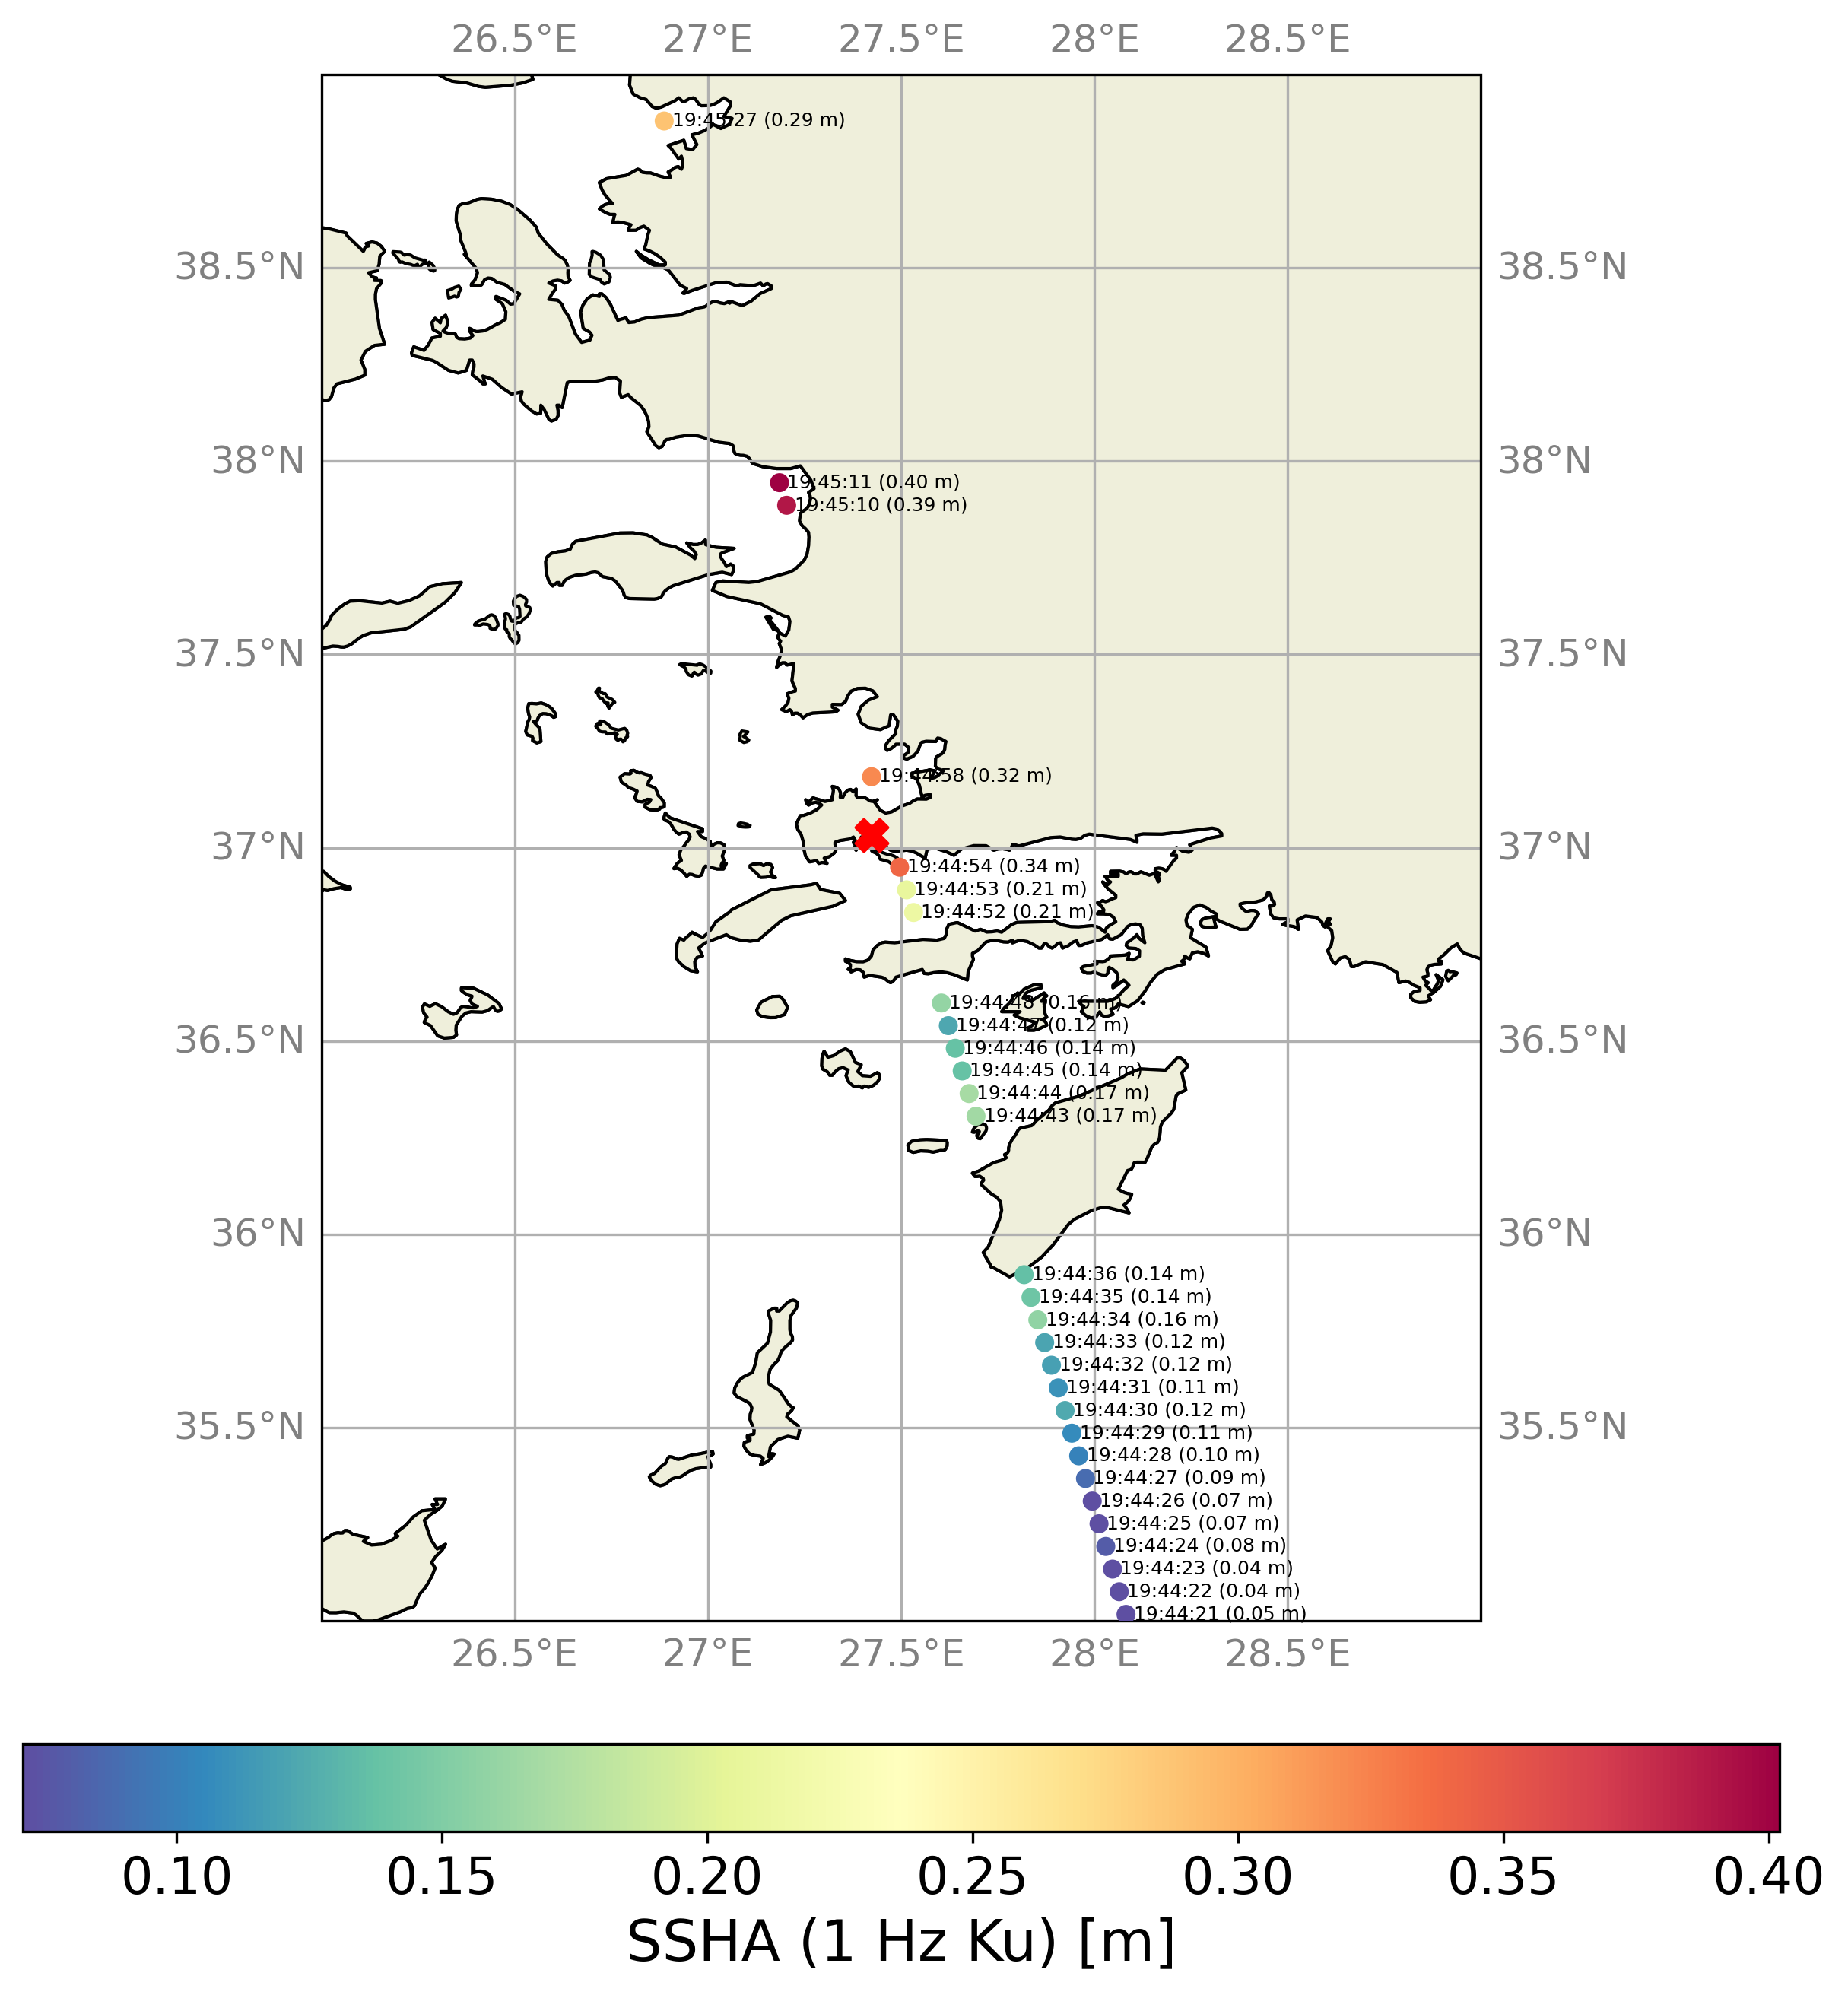

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()

# Build land
land_resolution = '10m'
land_poly = cfeature.NaturalEarthFeature(
    'physical', 'land', land_resolution,
    edgecolor='k',
    facecolor=cfeature.COLORS['land']
)

fig1 = plt.figure(figsize=(10, 10), dpi=300)

# DF
ssha = nc_data.variables[ssha_satellite][:].filled(np.nan)
lat  = nc_data.variables[lat_satellite][:]
lon  = nc_data.variables[lon_satellite][:]
err  = nc_data.variables["range_ocean_rms_01_ku"][:].filled(np.nan)
time = [pd.Timestamp(str(t)) for t in dtime]   # convert to pandas timestamps


d2c = nc_data.variables["dist_coast_01"][:].filled(np.nan)

df = pd.DataFrame({"time": time, "lat": lat, "lon": lon, "ssha": ssha, "quality": quality,"error":err,"d2c":d2c})

# Cleaning the dataset
df = df.dropna()
df = df[np.abs(df["ssha"]) <= 1]
df = df[np.abs(df["quality"]) == 0]

# Projection
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))

# SSHA range
low_pc  = np.percentile(df["ssha"], 20)
high_pc = np.percentile(df["ssha"], 100)
df["ssha_clipped"] = df["ssha"].clip(lower=low_pc, upper=high_pc)

# Bound
m.set_extent([26, 29, 35, 39], crs=ccrs.PlateCarree())

# Plot
f1 = m.scatter(
    df["lon"], df["lat"], c=df["ssha_clipped"],
    cmap='Spectral_r', marker='o',
    edgecolors=None, linewidth=0.0,
    vmin=low_pc, vmax=high_pc,
    transform=ccrs.PlateCarree(), zorder=5
)

# Map features
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)

g1 = m.gridlines(draw_labels=True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 12, 'color': 'gray'}
g1.ylabel_style = {'size': 12, 'color': 'gray'}

# Spectrum
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('SSHA (1 Hz Ku) [m]', size=18)

# Tide gauge
m.scatter(
    [27.423453], [37.03217],
    transform=ccrs.PlateCarree(),
    color="red", s=100, marker="X", zorder=5
)

# Temporal range
start = pd.Timestamp("2025-08-05 19:44:21")
end   = pd.Timestamp("2025-08-05 19:45:30")

for _, row in df[(df["time"] >= start) & (df["time"] <= end)].iterrows():
    label = row["time"].strftime("%H:%M:%S") + f" ({row['ssha']:.2f} m)"
    m.text(
        row["lon"]+0.02, row["lat"]-0.012, label,
        transform=ccrs.PlateCarree(),
        fontsize=6, color="black", zorder=6
    )

plt.savefig('fig_range')
plt.show()


**Attribution: Above plot contains data from EUMETSAT Metop SRAL Level 2 Altimetry Global - Sentinel-3 (2025)**

The map above shows no problematic points now. Let's have look at the final dataframe:

In [16]:
df

,time,lat,lon,ssha,quality,error,d2c,ssha_clipped
5,2025-08-05 19:43:11,30.909068,29.259179,0.264,0.0,0.0416,5774,0.264
6,2025-08-05 19:43:12,30.967807,29.242913,0.224,0.0,0.0381,12375,0.224
7,2025-08-05 19:43:13,31.026543,29.226631,0.248,0.0,0.0361,19032,0.248
8,2025-08-05 19:43:14,31.085279,29.210335,0.273,0.0,0.0437,25693,0.273
9,2025-08-05 19:43:15,31.144012,29.194023,0.268,0.0,0.0332,32346,0.268
...,...,...,...,...,...,...,...,...
249,2025-08-05 19:51:06,58.488439,18.212523,0.166,0.0,0.0332,34139,0.166
250,2025-08-05 19:51:07,58.545323,18.175875,0.159,0.0,0.0645,27824,0.159
251,2025-08-05 19:51:08,58.602198,18.139122,0.151,0.0,0.0455,21772,0.151
252,2025-08-05 19:51:09,58.659064,18.102263,0.147,0.0,0.0426,16118,0.147


Plotting the SSHA for the cleaned dataset:

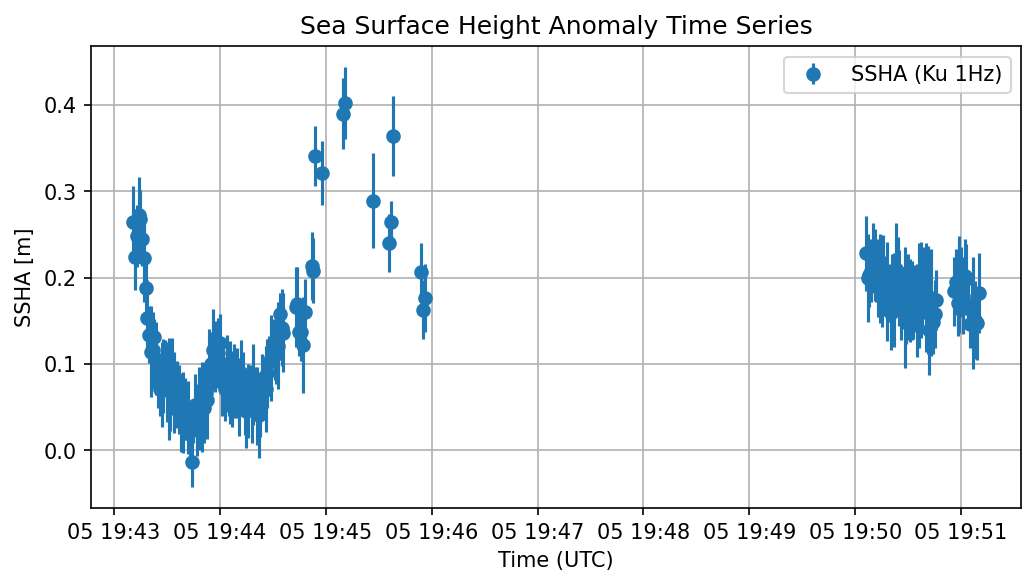

In [17]:
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
#ax.plot(df["time"], df["ssha"], "o-", label="SSHA")
plt.errorbar(df["time"], df["ssha"], yerr=df['error'], fmt="o",label="SSHA (Ku 1Hz)")
plt.xlabel("Time (UTC)")
plt.ylabel("SSHA [m]")
plt.title("Sea Surface Height Anomaly Time Series")
plt.legend()
plt.grid(True)
plt.show()

**Attribution: Above plot contains data from EUMETSAT Metop SRAL Level 2 Altimetry Global - Sentinel-3 (2025)**

No wild fluctuations are seen this time. There are gaps in the data where satellite was flying over land. Our map above does not show beyond 19:46 as this is where satellite leaves the Aegean area. So we can limit ourselves up to 19:46 in the following.

## In-situ tide gauge dataset

Based on the temporal determinations done previously, we create a tide gauge dataset covering 19:43-19:46 range on the same day. Using 12h mean as the subtraction reference, we have the final dataset of variations relative to the mean. We will simply call both values SSHA for convenience, although we should note that this is not conventional usage.

In [18]:
# Create the dataframe with original values
bodrum_tg = {
    "time": [
        "2025-08-05 19:43:00",
        "2025-08-05 19:43:30",
        "2025-08-05 19:44:00",
        "2025-08-05 19:44:30",
        "2025-08-05 19:45:00",
        "2025-08-05 19:45:30",
        "2025-08-05 19:46:00",
        "2025-08-05 19:46:30",
        "2025-08-05 19:47:00",
    ],
    "value": [
        1.891, 1.890, 1.890, 1.890, 1.889, 1.889, 1.889, 1.888, 1.888
    ]
}

df_tg = pd.DataFrame(bodrum_tg)
df_tg["time"] = pd.to_datetime(df_tg["time"])
df_tg["ssha"] = df_tg["value"]-1.86
print(df_tg["value"].mean())

1.889333333333333


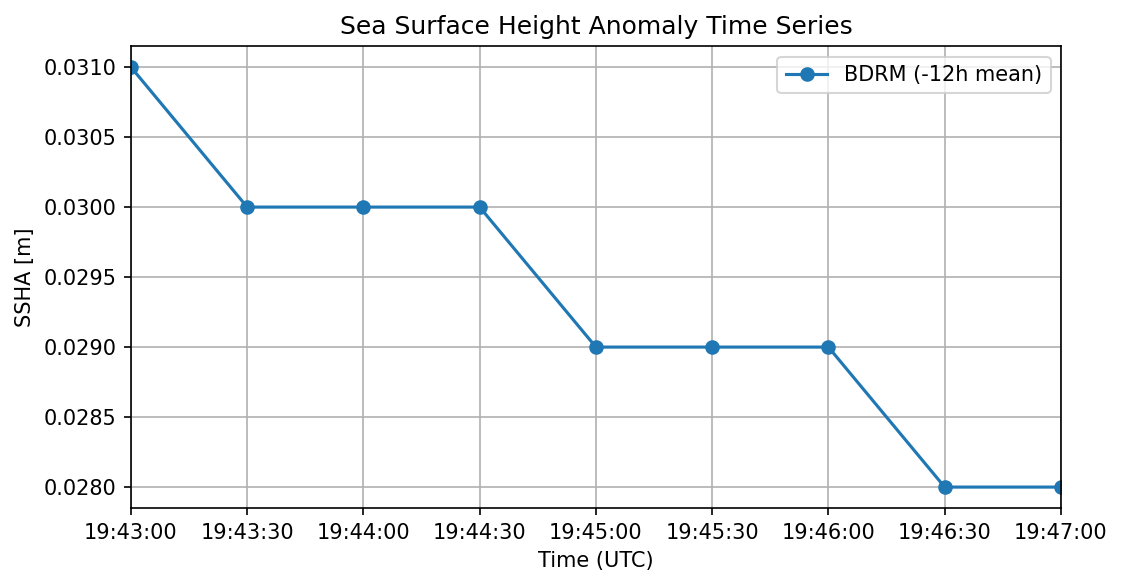

In [19]:
# Load and ensure datetime parsing

# Assume df_tg already has datetime parsed
start_time = df_tg["time"].min().floor("min")   # round down to start of minute
end_time   = df_tg["time"].max().ceil("min")    # round up to end of minute

fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax.plot(df_tg["time"], df_tg["ssha"], "o-", label="BDRM (-12h mean)")

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))  # ticks every 30s

# Force x-axis range
ax.set_xlim(start_time, end_time)

plt.xlabel("Time (UTC)")
plt.ylabel("SSHA [m]")
plt.title("Sea Surface Height Anomaly Time Series")
plt.legend()
plt.grid(True)
plt.show()

The variations are almos an order of magnitude smaller than satellite observations.

## Comparison of both altimetry measurements

In [20]:
# Set index
df = df.set_index("time")
df_tg = df_tg.set_index("time")
df_resampled = df.resample("30S").mean()
df_quad = df.interpolate(method="quadratic")
df_resampled_quad = df.resample("30S").mean().interpolate(method="quadratic")

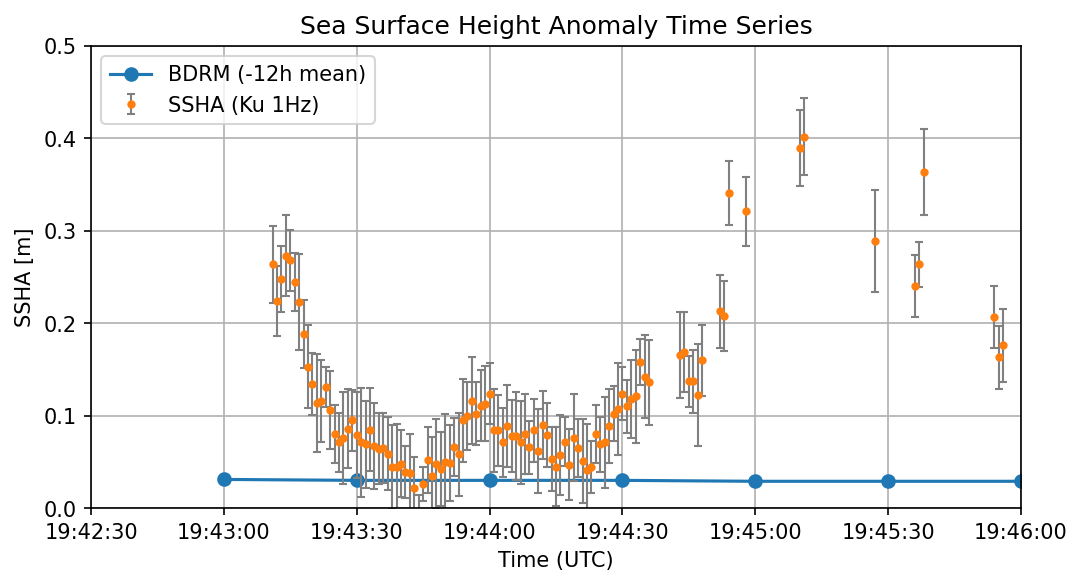

In [21]:
start_time = pd.Timestamp("2025-08-05 19:42:30")
end_time   = pd.Timestamp("2025-08-05 19:46:00")

# Plot
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ax.plot(df_tg.index, df_tg["ssha"], "o-", label="BDRM (-12h mean)")

ax.errorbar(
    df.index,
    df["ssha"],
    yerr=df["error"],
    fmt=".",             
    ecolor="gray",        
    elinewidth=1,         
    capsize=2,           
    label="SSHA (Ku 1Hz)"
)
# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))  # ticks every 30s

# Force x-axis range
ax.set_xlim(start_time, end_time)
ax.set_ylim(0.0, 0.5)

plt.xlabel("Time (UTC)")
plt.ylabel("SSHA [m]")
plt.title("Sea Surface Height Anomaly Time Series")
plt.legend()
plt.grid(True)
plt.show()


**Attribution: Above plot contains data from EUMETSAT Metop SRAL Level 2 Altimetry Global - Sentinel-3 (2025)**

Satellite data is so large that tide gauge variations are not visible on this plot anymore. They seem to match best around 19:43-19:44:30 and there is a peak in discrepancy around 19:45:15. We know from map that nearest data point to the actual was recorded on 19:44:54. So everything before was approaching from south and afterwards flying away towards north. So it is rather close to the peak, where agreement was worst. Let's add this distance to the plot and also average the measurements over 30seconds to match to that of the gauge:

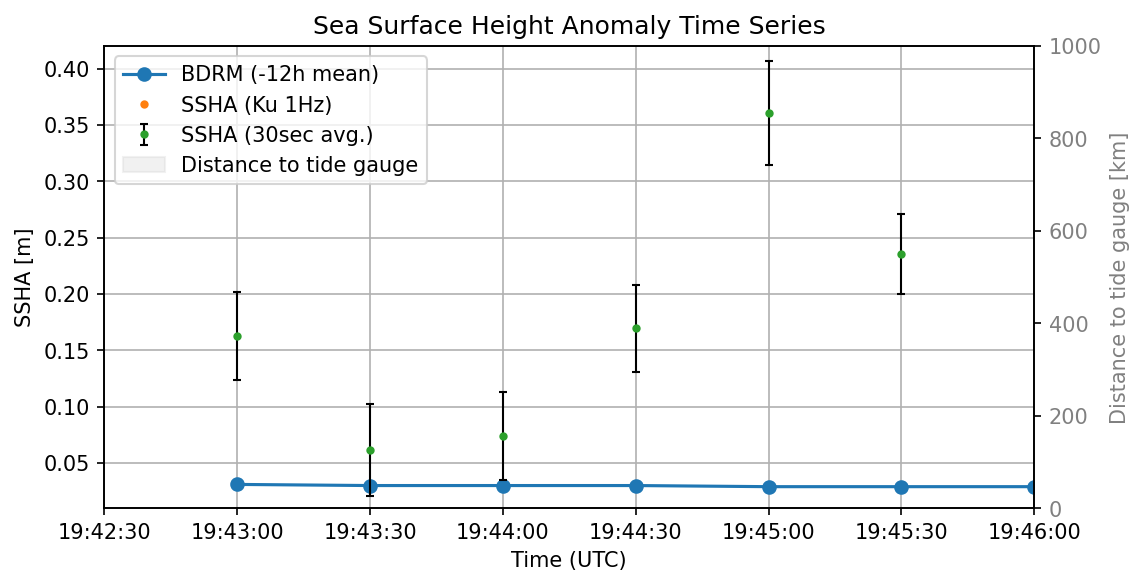

In [25]:
from geopy.distance import geodesic

# Define tide gauge location
tg_coords = (37.03217, 27.423453)

# Compute distance for each satellite sample in df
distances = [
    geodesic((lat, lon), tg_coords).km
    for lat, lon in zip(df["lat"], df["lon"])
]

# Plot
fig, ax = plt.subplots(figsize=(8,4), dpi=150)

# Left axis: SSHA
ax.plot(df_tg.index, df_tg["ssha"], "o-", label="BDRM (-12h mean)")
ax.plot(df.index, df["ssha"], ".", label="SSHA (Ku 1Hz)")

ax.errorbar(
    df_resampled.index,
    df_resampled["ssha"],
    yerr=df_resampled["error"],
    fmt=".",             
    ecolor="black",  
    elinewidth=1,    
    capsize=2,      
    label="SSHA (30sec avg.)"
)
# Formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
ax.set_xlim(start_time, end_time)
ax.set_ylim(0.01, 0.42)
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("SSHA [m]")
ax.set_title("Sea Surface Height Anomaly Time Series")
#ax.legend(loc="upper left")
ax.grid(True)


ax2 = ax.twinx()
ax2.fill_between(df.index, distances, color="lightgray", alpha=0.3, label="Distance to tide gauge")
ax2.set_ylabel("Distance to tide gauge [km]", color="gray", zorder=0)
ax2.tick_params(axis="y", labelcolor="gray")
ax2.set_ylim(0.0, 1000)
# Add legend for secondary axis
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

plt.show()

**Attribution: Above plot contains data from EUMETSAT Metop SRAL Level 2 Altimetry Global - Sentinel-3 (2025)**

Despite the naive assumption that closer in spatio-temporal space to the gauge, better the match would be. We get something opposite. Generally being closer to coast induces measurement errors and difficulties as previously seen with quality flags. It looks like here we suffer from this issue as well. Let's instead look at the distance to nearest coast for each data point:

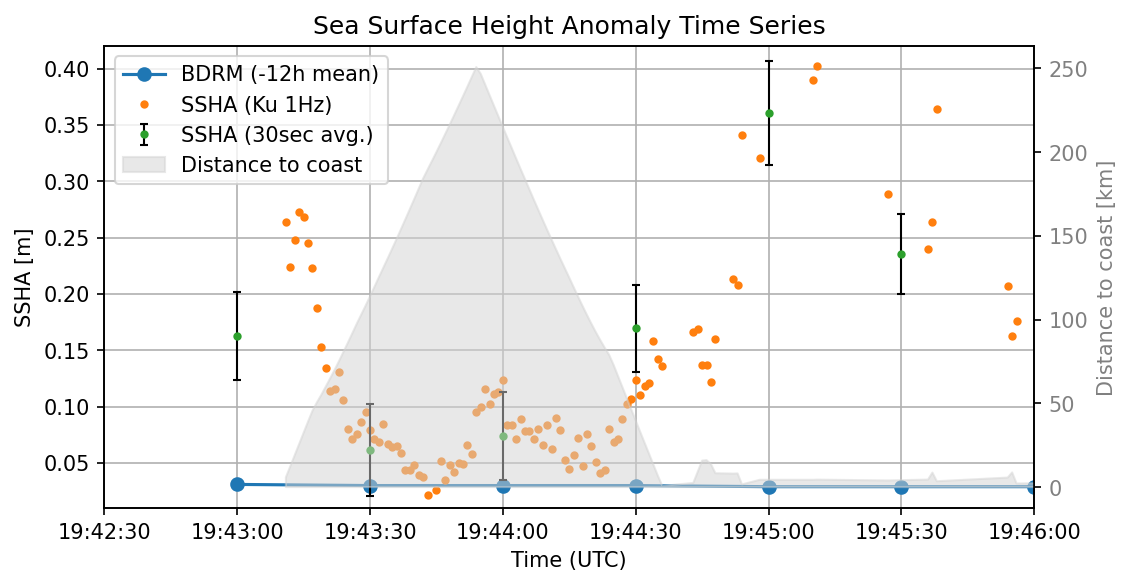

In [23]:
from geopy.distance import geodesic

# Plot
fig, ax = plt.subplots(figsize=(8,4), dpi=150)

# Left axis: SSHA
ax.plot(df_tg.index, df_tg["ssha"], "o-", label="BDRM (-12h mean)")
ax.plot(df.index, df["ssha"], ".", label="SSHA (Ku 1Hz)")

ax.errorbar(
    df_resampled.index,
    df_resampled["ssha"],
    yerr=df_resampled["error"],
    fmt=".",             
    ecolor="black",        
    elinewidth=1,       
    capsize=2,           
    label="SSHA (30sec avg.)"
)
# Formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=30))
ax.set_xlim(start_time, end_time)
ax.set_ylim(0.01, 0.42)
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("SSHA [m]")
ax.set_title("Sea Surface Height Anomaly Time Series")
#ax.legend(loc="upper left")
ax.grid(True)


ax2 = ax.twinx()
ax2.fill_between(df.index, df["d2c"]/1000, color="lightgray", alpha=0.5, label="Distance to coast", zorder=0)
ax2.set_ylabel("Distance to coast [km]", color="gray", zorder=0)
ax2.tick_params(axis="y", labelcolor="gray")

# Add legend for secondary axis
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")
plt.show()

**Attribution: Above plot contains data from EUMETSAT Metop SRAL Level 2 Altimetry Global - Sentinel-3 (2025)**

Although it is difficult to say that the trend is valid for small variations in distance, the dip and the peak locations at least match closely with the maxima of the distance to coast.

## Outlook

This study is far from being exhaustive. It was done to practice the tools learned in tutorial and apply them independently in another context. I have learned meanwhile of other criteria regarding altimetry vs. tide gauge comparisons/validations. Next step would be to apply these criteria (correlation, maximum difference) as well as study multiple fly-bys and pick the distance point with highest correlation. Some links for future study:

- https://user.eumetsat.int/s3/eup-strapi-media/COPAS_4600002662_annual_report_Alti_TG_202310_96e368cd97.pdf
- https://www.mdpi.com/2072-4292/15/4/1132
- https://www.aviso.altimetry.fr/fileadmin/documents/calval/validation_report/annual_report_insitu_TG_2013.pdf
- https://www.sciencedirect.com/science/article/pii/S0273117724000991
- https://os.copernicus.org/articles/18/331/2022/